In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import json
from fastqaoa.ctypes import Diagonals
from fastqaoa.ctypes.metrics import Metrics
import numpy as np

import matplotlib.pyplot as plt

import pandas as pd

In [3]:
with open("qzd_problem_instances.json", "r") as f:
    instances = json.load(f)

In [4]:
N = 7

instance = instances["single"][str(N)]

sigma = instance["sigma"]
mu = instance["mu"]

risk = instance["risk_factor"]
budget = instance['budget']

print(budget)

k = [(1 << i) | (1 << j) for i in range(N) for j in range(N)]
v = [risk * sigma[i][j] for i in range(N) for j in range(N)]

k += [1 << i for i in range(N)]
v += [-m for m in mu]
# k += [0]
# v += [-np.abs(np.array(sigma)).sum()]

dg = Diagonals.brute_force(N, k, v)
f = dg.n_qubits / (max(-dg.min_val, dg.max_val) *  2)
dg = dg * f
print(f)

shift =  dg.max_val
dg = dg + (-1 * shift)

cap = Diagonals.brute_force(N, [1 << i for i in range(N)], -np.ones(N)) + budget

print((cap < 0).to_numpy().sum())

x = dg.mask(cap, 0, Diagonals.GTE)
z = dg.mask(cap, 0, Diagonals.GTE, 1)

3
47.26039689977324
64.0


(array([ 1.,  2.,  1.,  1.,  1.,  2.,  3.,  1.,  3.,  3.,  2.,  0.,  4.,
         3.,  2.,  2.,  3.,  2.,  2.,  1.,  1.,  1.,  0.,  1.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  3.,  0.,
         0.,  3.,  3.,  0.,  4.,  3.,  1.,  3., 66.]),
 array([-4.45432291, -4.40977968, -4.36523645, -4.32069322, -4.27615   ,
        -4.23160677, -4.18706354, -4.14252031, -4.09797708, -4.05343385,
        -4.00889062, -3.96434739, -3.91980416, -3.87526093, -3.8307177 ,
        -3.78617448, -3.74163125, -3.69708802, -3.65254479, -3.60800156,
        -3.56345833, -3.5189151 , -3.47437187, -3.42982864, -3.38528541,
        -3.34074218, -3.29619895, -3.25165573, -3.2071125 , -3.162569

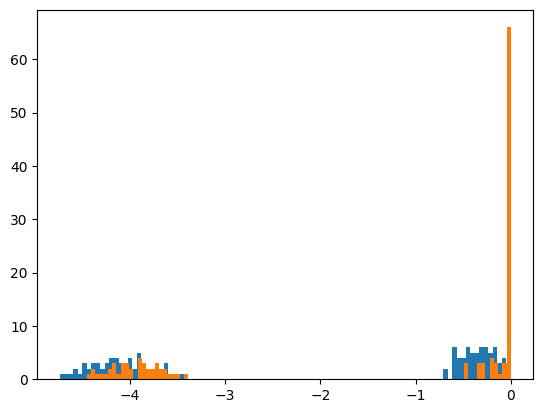

In [5]:
plt.hist(dg.to_numpy(), bins=100)
plt.hist(x.to_numpy(), bins=100)

0.2432797613158341


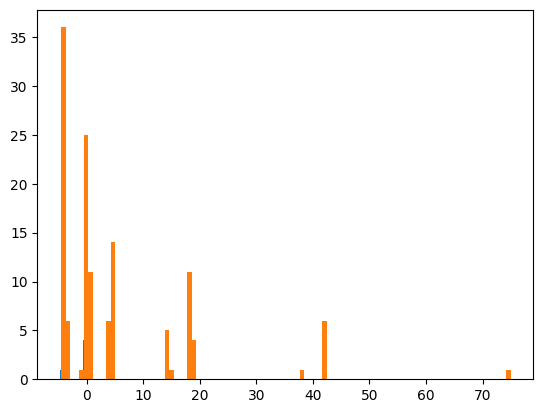

In [6]:
y, pf = dg.quad_penalty(cap, 0, Diagonals.GTE, f*0.1)
y_opt, pf = dg.quad_penalty(cap, 0, Diagonals.GTE)


print(pf)

plt.hist(dg.to_numpy(), bins=100)
plt.hist(y.to_numpy(), bins=100)
print(y)

In [7]:
from fastqaoa.optimize import optimize_interpolate
from fastqaoa.ctypes.optimize import optimize_qaoa_lbfgs
from fastqaoa.ctypes.qaoa import qaoa


hc = x
res = optimize_interpolate(hc, x, [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16], init_val=0.1, tol=1e-2, maxiter=100)
k = max(res.keys())


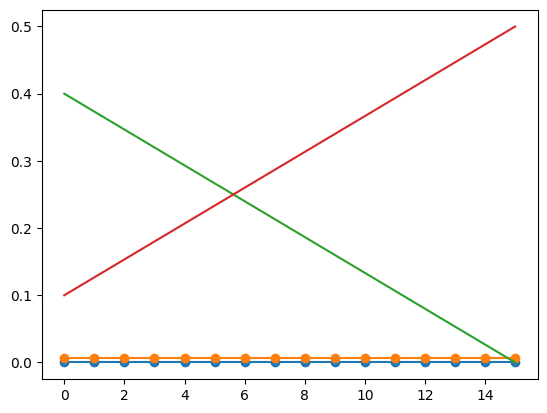

In [8]:
plt.plot(res[k].betas, marker="o")
plt.plot(res[k].gammas, marker="o")

plt.plot([0, 15], [0.4, 0.0])
plt.plot([0, 15], [0.1, 0.5])

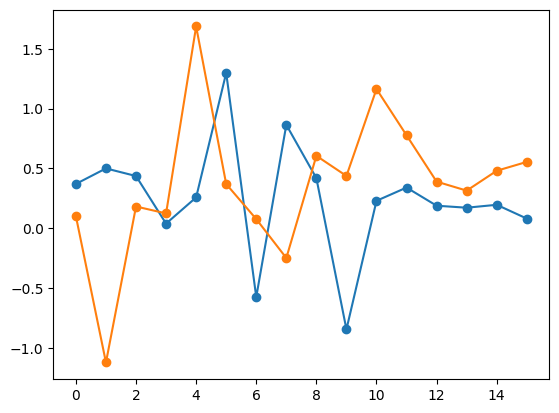

In [9]:
betas = np.linspace(0.4, 0.01, 16)
gammas = np.linspace(0.1, 0.5, 16)

res = optimize_qaoa_lbfgs(x, x, betas, gammas, tol=1e-5, maxiter=1000)

plt.plot(res.betas, marker="o")
plt.plot(res.gammas, marker="o")

In [14]:
data = []

for instance in instances["single"].values():
    sigma = instance["sigma"]
    mu = instance["mu"]
    size = len(mu)
    N = size


    risk = instance["risk_factor"]
    budget = instance['budget']


    k = [(1 << i) | (1 << j) for i in range(N) for j in range(N)]
    v = [risk * sigma[i][j] for i in range(N) for j in range(N)]

    k += [1 << i for i in range(N)]
    v += [-m for m in mu]
    
    dg = Diagonals.brute_force(N, k, v)
    f = dg.n_qubits / (max(-dg.min_val, dg.max_val) *  2)
    dg = dg * f
    
    shift =  dg.max_val
    dg = dg + (-1 * shift)

    cap = Diagonals.brute_force(N, [1 << i for i in range(N)], -np.ones(N)) + budget

    x = dg.mask(cap, 0, Diagonals.GTE)

    y, pf = dg.quad_penalty(cap, 0, Diagonals.GTE, f*0.1)
    y_opt, pf = dg.quad_penalty(cap, 0, Diagonals.GTE)

    print(y.max_val)

    hcs = {"masked": x, "penalty": y, "penalty_opt": y_opt}

    depths = np.arange(1, 16)
    for n, hc in hcs.items():
        res = optimize_interpolate(hc, x, depths, init_val=0.1, tol=1e-10, maxiter=200)

        for i, r in res.items():
            sv = qaoa(hc, r.betas, r.gammas)

            metrics = Metrics.compute(sv, x, cap)
            # r2 = (metrics.approx_ratio * hc.min_val - hc.max_val) / (hc.min_val - hc.max_val)
            data.append({"qaoa": n, "depth": i, "size": size, **metrics.dump()})

df = pd.DataFrame(data)

0.0
79.26200187722345
246.2318320642455
75.00491443866211
267.2209539997798
75.22767755946086
472.0497308592167


<Axes: xlabel='depth', ylabel='approx_ratio'>

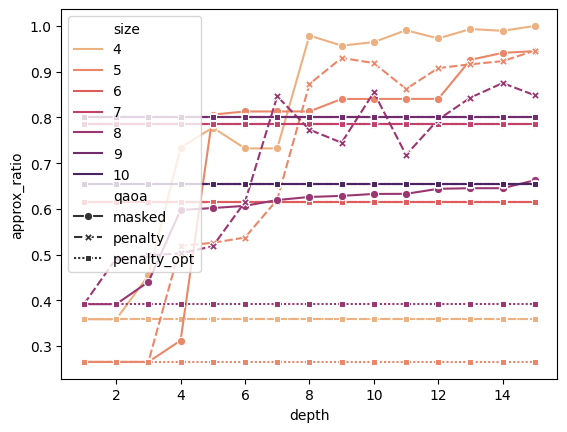

In [17]:
import seaborn as sns
sns.lineplot(df, x="depth", y="approx_ratio", hue="size", style="qaoa", palette="flare", markers=True)


<Axes: xlabel='depth', ylabel='feas_ratio'>

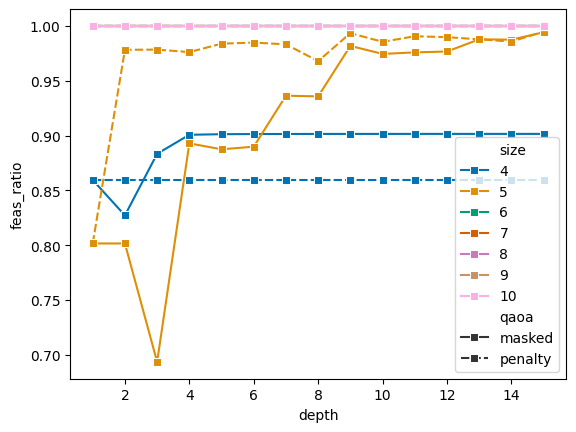

In [12]:
sns.lineplot(df.query("qaoa != 'penalty_opt'"), x="depth", y="feas_ratio", hue="size", style="qaoa", palette="colorblind", marker="s")

In [13]:
N = 

instance = instances["multi"][str(N)]

sigma = instance["sigma"]
mu = instance["mu"]

risk = instance["risk_factor"]
budget = instance['budget']

min_return = instance["min_return"]


print(budget)

k = [(1 << i) | (1 << j) for i in range(N) for j in range(N)]
v = [risk * sigma[i][j] for i in range(N) for j in range(N)]

k += [1 << i for i in range(N)]
v += [-m for m in mu]
# k += [0]
# v += [-np.abs(np.array(sigma)).sum()]

dg = Diagonals.brute_force(N, k, v)
dg = dg + (-1) * dg.max_val

cap = Diagonals.brute_force(N, [1 << i for i in range(N)], -np.ones(N)) + budget
print((cap < 0).to_numpy().sum())

cap2 = Diagonals.brute_force(N, [1 << i for i in range(N)], mu)
print((cap < min_return).to_numpy().sum())

cap3 = Diagonals.from_numpy((cap >= 0).to_numpy() * (cap2 >= min_return).to_numpy())

x = dg.mask(cap3, 0, Diagonals.GT)

SyntaxError: invalid syntax (1400453298.py, line 1)

In [ ]:
_ = plt.hist(dg.to_numpy(), bins=100, range=(-0.06, 0))
plt.hist(x.to_numpy(), bins=100, range=(-0.06, 0))